In this file I want to extract create a border which is the one of the real, and fill it with the values of a thickness average,calculated on the front of the thickness dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation

import imageio 
import os
import netCDF4 as nc
import matplotlib as mpl
import shapefile
import pyproj

import fiona
from shapely.geometry import shape
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

from scipy.ndimage import binary_dilation

from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal

In [2]:
common_years = np.arange(2005,2017,1)

selecao_path = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/selecao.txt' #CHANGE IN CLUSTER
ids_selecao = np.loadtxt(selecao_path, dtype=int)

In [3]:
#get information from the shp file, without creating the output tif files

shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
boundaries = []

shapefile=fiona.open(shapefile_path)

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue

    bounds=shape(geometry).bounds

    #I expand the boundaries of 5000 m (10 pixels)
    xmin=bounds[0]-5000;ymin=bounds[1]-5000;xmax=bounds[2]+5000;ymax=bounds[3]+5000

    #Condition for Twaithes
    if id == 56:
        xmin=bounds[0]-57000;ymin=bounds[1]-50000;xmax=bounds[2]+50000;ymax=bounds[3]+10000


    #Taking the info
    ids.append(id)
    Names.append(name)
    boundaries.append([xmin,xmax,ymin,ymax])

#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'boundaries': boundaries}, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)
#Select just selecao
df = df[np.isin(df.index, ids_selecao)]

In [4]:
#Importing the coastlines and creating the file names

root = '/Users/francesco/Desktop/Thesis/Coastlines/dataset/JPL_iceshelves_geometryJPL_antarctic_coastline_' #CHANGE IN CLUSTER
end = '_filled.tif'

file_names_coast = [] 

for year in common_years:

    file_names_coast.append(root+str(year)+end)

In [5]:
#Preparing the masks dataframe

ice_mask = pd.DataFrame(index = df.index, columns = common_years)
grounded_ice_mask = pd.DataFrame(index = df.index, columns = common_years)
sea_mask = pd.DataFrame(index = df.index, columns = common_years)
land_mask = pd.DataFrame(index = df.index, columns = common_years)

In [6]:
#Here I am creating the masks from the new shape file

for file, year in zip(file_names_coast, common_years):

    print(year)

    for id in df.index: #df_region.index:

        with rasterio.open(file, crs='EPSG:3031') as src:

            xmin, xmax, ymin, ymax = df['boundaries'].loc[id]
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
            image = src.read(1, window=window)

            # Initialize boolean masks with the same shape as the window
            ice_mask_tmp = np.zeros_like(image, dtype=bool)
            sea_mask_tmp = np.zeros_like(image, dtype=bool)
            land_mask_tmp = np.zeros_like(image, dtype=bool)
            grounded_ice_mask_tmp = np.zeros_like(image, dtype=bool)

            # Update masks based on conditions
            ice_mask_tmp[image == 3] = True
            sea_mask_tmp[image == 0 ] = True
            land_mask_tmp[image == 2] = True
            grounded_ice_mask_tmp[image == 1] = True

            #save the masks
            ice_mask.loc[id, year] = ice_mask_tmp 
            sea_mask.loc[id, year] = sea_mask_tmp 
            land_mask.loc[id, year] = land_mask_tmp
            grounded_ice_mask.loc[id, year] = grounded_ice_mask_tmp

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [9]:
#Save all the datasets

'''np.save(os.getcwd()+'/ice_mask.npy', ice_mask) #CHANGE IN CLUSTER
np.save(os.getcwd()+'/sea_mask.npy', sea_mask)
np.save(os.getcwd()+'/land_mask.npy', land_mask)
np.save(os.getcwd()+'/grounded_ice_mask.npy', grounded_ice_mask)'''


In [7]:
#load the datasets

ice_mask = np.load(os.getcwd()+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
sea_mask = np.load(os.getcwd()+'/sea_mask.npy', allow_pickle=True)
land_mask = np.load(os.getcwd()+'/land_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(os.getcwd()+'/grounded_ice_mask.npy', allow_pickle=True)

#crete the dataframes
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)


Now I will extract the front

In [8]:
#Here i expand the sea mask of 10 pixels
sea_mask_expanded = sea_mask.copy()

for year in common_years:
    
        for id in df.index:
    
            sea_mask_tmp = sea_mask_expanded.loc[id, year]
            sea_mask_tmp = binary_dilation(sea_mask_tmp, iterations=15)
            sea_mask.loc[id, year] = sea_mask_tmp

In [9]:
# Selecting the thickness which is in the sea mask expanded !!!!!!! PROBLEMS WITH THE SMALL ONES!!!!!!

thickness_average = pd.DataFrame(index = ids_selecao, columns = common_years)
problematic_regions = []

#creating the list of files
root = '/Users/francesco/Desktop/Thesis/Thickness/Thickness_dataset/thickness_' #CHANGE IN CLUSTER
end = '_warp_ps.tif'
file_list_thickness = []

for year in common_years:
    file_list_thickness.append(root + str(year) + end)

i =0

for file, year in zip(file_list_thickness, common_years): 

    print('The year is ', str(year))
 
    for id in df.index:  # region

        xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)

            image = src.read(1, window=window) #this is the thickness

            #Mask where is not nan
            mask_not_a_nan = ~np.isnan(image)

            #mask were there is the expanded sea
            sea_mask_expanded_tmp = sea_mask_expanded.loc[id, year]

            #mask where there is the expanded sea and is not nan
            roi_mask = mask_not_a_nan & sea_mask_expanded_tmp

            #selecting the thickness in the region of the roi mask
            thickness_average.loc[id,year] = np.nanmean(image[roi_mask])

            #check if image[roi_mask] is empty
            if np.all(np.isnan(image[roi_mask])):
                thickness_average.loc[id,year] = np.nanmin(image[~np.isnan(image)])
                #print('The region ', id, ' is empty, i have selected the minimum thickness. which is ', thickness_average.loc[id,year])

                if i == 0:
                    problematic_regions.append(id)
                continue
    i =1              

The year is  2005


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_19129/992578343.py:40: RuntimeWarning: Mean of empty slice
  thickness_average.loc[id,year] = np.nanmean(image[roi_mask])


The year is  2006
The year is  2007
The year is  2008
The year is  2009
The year is  2010
The year is  2011
The year is  2012
The year is  2013
The year is  2014
The year is  2015
The year is  2016


In [10]:
problematic_regions

[2,
 15,
 17,
 19,
 33,
 43,
 47,
 48,
 57,
 62,
 76,
 77,
 85,
 92,
 93,
 105,
 108,
 111,
 127,
 132,
 136,
 139,
 140,
 144,
 164,
 166,
 169,
 170]

In [11]:
##Here i expand the front of the sea by 1 pixels
sea_mask = np.load(os.getcwd()+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)

for year in common_years:
    
        for id in df.index:
    
            sea_mask.loc[id, year] = binary_dilation(sea_mask.loc[id, year], iterations=1)

In [12]:
#Here I select the borders of the ice shelves

borders = pd.DataFrame(index = df.index, columns = common_years)

for year in common_years:
    
        for id in df.index:
    
            borders.loc[id, year] = ice_mask.loc[id, year] & sea_mask.loc[id, year]

In [13]:
#save the borders
np.save(os.getcwd()+'/new_borders.npy', borders) 


In [14]:
#load the borders
borders = np.load(os.getcwd()+'/new_borders.npy', allow_pickle=True)

#create the dataframe
borders = pd.DataFrame(borders, index = df.index, columns = common_years)

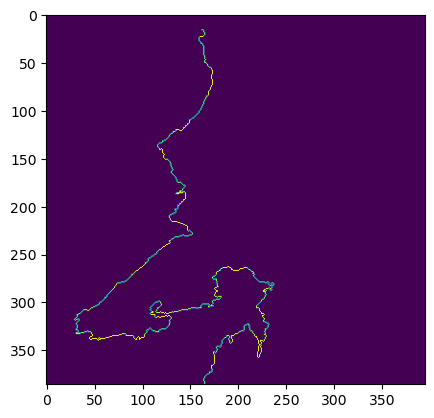

In [15]:
plt.imshow(borders.loc[56,2005])

From now on I try to fill the image of the borders and the thickenss which is inside

In [16]:
#Load bedmachine

bed_machine_tif_address = '/Users/francesco/Desktop/Thesis/Data/Bed_Machine_thickness.tif'
    

In [46]:
#Loading thickness and merging it with bed machine

thickness_tif = pd.DataFrame(index = df.index, columns = common_years)

#creating the list of files
root = '/Users/francesco/Desktop/Thesis/Thickness/Thickness_dataset/thickness_'
end = '_warp_ps.tif'
file_list = []

for year in common_years:
    file_list.append(root + str(year) + end)

#reload the masks
sea_mask = np.load(os.getcwd()+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)

for id in df.index:

    print('Region ', id)
    xmin,xmax,ymin,ymax = df['boundaries'].loc[id]

    #Here I am extracting the bedmachine thickness, which is the same for all the years
    with rasterio.open(bed_machine_tif_address, crs='EPSG:3031') as src:

        window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)
        thickness_bm = src.read(1, window=window)

    for file, year in zip(file_list, common_years): 

        with rasterio.open(file, crs='EPSG:3031') as src:
        
            window = rasterio.windows.from_bounds(xmin,ymin,xmax,ymax,transform=src.transform)
            image = src.read(1, window=window) #this is thickenss

            #Here i extract the thickness where there is the ice mask
            thickness_tmp = np.where(ice_mask.loc[id,year] == True, image, np.nan)
            thickness_tmp = np.where(borders.loc[id,year] == True, thickness_average.loc[id, year] ,thickness_tmp)

            thickness_tmp =np.where(land_mask.loc[id,year] == True, thickness_bm, thickness_tmp)
            thickness_tmp =np.where(grounded_ice_mask.loc[id,year] == True, thickness_bm, thickness_tmp)

            #Here I set to 0 all the values where there is the sea mask
            thickness_tmp = np.where(sea_mask.loc[id,year] == True, 0, thickness_tmp)                
        
            thickness_tif.loc[id,year] = thickness_tmp


Region  2
Region  3
Region  4
Region  6
Region  7
Region  8
Region  10
Region  12
Region  15
Region  16
Region  17
Region  18
Region  19
Region  24
Region  26
Region  29
Region  30
Region  31
Region  32
Region  33
Region  34
Region  35
Region  36
Region  37
Region  38
Region  39
Region  40
Region  41
Region  43
Region  44
Region  45
Region  46
Region  47
Region  48
Region  50
Region  52
Region  53
Region  54
Region  55
Region  56
Region  57
Region  58
Region  60
Region  61
Region  62
Region  63
Region  64
Region  65
Region  66
Region  67
Region  68
Region  69
Region  70
Region  71
Region  72
Region  73
Region  75
Region  76
Region  77
Region  78
Region  80
Region  81
Region  82
Region  83
Region  84
Region  85
Region  86
Region  87
Region  88
Region  89
Region  90
Region  91
Region  92
Region  93
Region  95
Region  96
Region  97
Region  98
Region  99
Region  100
Region  101
Region  102
Region  104
Region  105
Region  107
Region  108
Region  109
Region  110
Region  111
Region  112
Regio

In [54]:
inteprolated_pixels = pd.DataFrame(index = df.index, columns = common_years)

for year in common_years:
    for id in df.index:
        inteprolated_pixels.loc[id,year] = np.where(np.isnan(thickness_tif.loc[id,year]),True,False)

In [58]:
#save the dataset interpolated pixels
#np.save(os.getcwd()+'/interpolated_pixels_thickness.npy', inteprolated_pixels)

#load the dataset interpolated pixels
inteprolated_pixels = np.load(os.getcwd()+'/interpolated_pixels_thickness.npy', allow_pickle=True)
inteprolated_pixels = pd.DataFrame(inteprolated_pixels, index = df.index, columns = common_years)

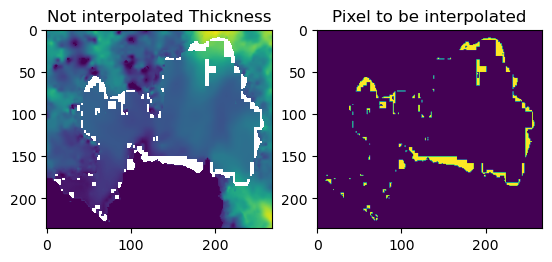

In [63]:
import matplotlib.pyplot as plt
id = 55
year =2010
# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.imshow(thickness_tif.loc[id, year])
plt.title("Not interpolated Thickness")

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.imshow(inteprolated_pixels.loc[id, year])
plt.title("Pixel to be interpolated")

plt.show()


Here i do the interpolation

In [20]:
#153 mins

#Here I inerpolate the values

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

interpolated_values = pd.DataFrame(index = df.index, columns = common_years)

for id in [56]:
    for year in common_years:
        print('Region ', id, 'Year ', year)

        # Get the coordinates where NaN values need to be interpolated
        thickness_nan_coords = np.where(np.isnan(thickness_tif.loc[id, year]))

        # Get the non-NaN values and their coordinates
        thickness_no_nan_coords = np.where(~np.isnan(thickness_tif.loc[id, year]))

        #Get the values
        thickness_no_nan_values = thickness_tif.loc[id, year][~np.isnan(thickness_tif.loc[id, year])]

        # Perform interpolation using griddata
        interpolated_values.loc[id,year] = griddata(thickness_no_nan_coords, thickness_no_nan_values, thickness_nan_coords, method='linear')


Region  56 Year  2005
Region  56 Year  2006
Region  56 Year  2007
Region  56 Year  2008
Region  56 Year  2009
Region  56 Year  2010
Region  56 Year  2011
Region  56 Year  2012
Region  56 Year  2013
Region  56 Year  2014
Region  56 Year  2015
Region  56 Year  2016


In [21]:
#Here i fill the nan values with the interpolated ones
thickness_tif_interpolated = thickness_tif.copy()

for id in [56]:
    for year in common_years:
        nan_indices = np.isnan(thickness_tif.loc[id, year])
        thickness_tif_interpolated.loc[id, year][nan_indices] = interpolated_values.loc[id, year]


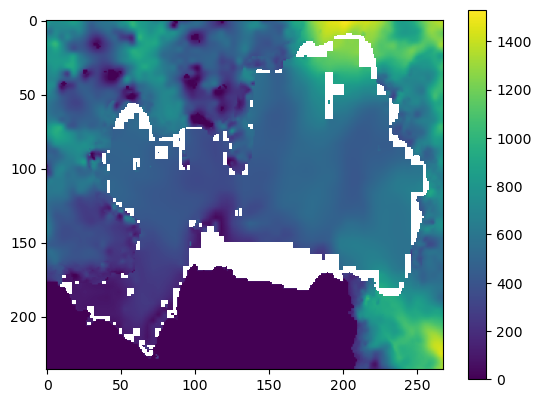

In [49]:
plt.imshow(thickness_tif.loc[55,2007])
plt.colorbar()

In [23]:
def fig_to_array(fig):
    fig.canvas.draw()
    return np.array(fig.canvas.renderer.buffer_rgba())


In [24]:
import imageio
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a Matplotlib figure to an array
def fig_to_array(fig):
    fig.canvas.draw()
    return np.array(fig.canvas.renderer.buffer_rgba())

# Create the frames
frames = []
for year in common_years:
    # Assuming thickness_tif is a DataFrame with image data
    new_frame = thickness_tif.loc[56, year]
    
    # Create a plot
    fig, ax = plt.subplots()
    
    # Display the image with a colormap of your choice (e.g., 'viridis')
    im = ax.imshow(new_frame, cmap='viridis')
    
    # Add a title with the current year
    ax.set_title(f'Thickness Map - Year {year}')
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.04, pad=0.1)
    cbar.set_label('Thickness')  # Customize the colorbar label
    
    # Append the plot to frames
    frames.append(fig_to_array(fig))
    
    # Close the plot to prevent memory leaks
    plt.close(fig)

# Save into a GIF file that loops forever
imageio.mimsave('thickness_region_56.gif', frames, 'GIF', duration=0.5)


In [34]:
prova = '/Users/francesco/Desktop/thickness_tif_interpolated.npy'

#Load the thickness_tif_interpolated
dio_cane = np.load(prova, allow_pickle=True)
dio_cane = pd.DataFrame(dio_cane, index = df.index, columns = common_years)


In [39]:
interpolated = '/Users/francesco/Desktop/Thesis/Thickness/just_interpolated.npy'

#Load the thickness_tif_interpolated
interpolated = np.load(interpolated, allow_pickle=True)
#interpolated = pd.DataFrame(interpolated, index = df.index, columns = common_years)

In [42]:
np.shape(interpolated)

(24, 12)

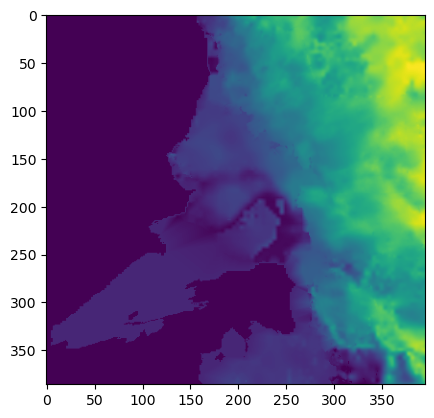

In [36]:
plt.imshow(dio_cane.loc[56,2010])

In [19]:
plt.imshow(thickness_tif.loc[55,2012])

NameError: name 'thickness_tif' is not defined

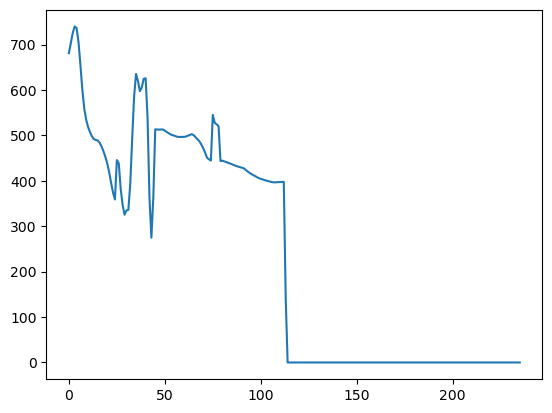

In [ ]:
plt.plot(dio_cane.loc[55,2016][:,140])